# Assignment 2

## General information

This assignment has three problems:
 - 1: Generative Classifiers
 - 2: Softmax Regression
 - 3: Ensemble Classifiers

Utilize the designated cells within this notebook to complete the exercises. As for the Python exercises:
- Refrain from altering the provided code; simply fill in the missing portions as indicated.
- Do not use any additional libraries beyond those already included in the code (e.g., NumPy library).
- Make sure that the output of all code cells is visible in your submitted notebook. **The evaluator is NOT expected to execute your code before grading your submission.**
- Some problems include automatic checks (*assertions*) to verify basic aspects of your solution. However, passing these assertions does not guarantee that your solution is entirely correct. The final evaluation will always be determined by the evaluator.
- Avoid the use of for loops by using NumPy vectorized operations whenever possible.
   
Please identify the authors of this assignment in the cell below.

## Identification

* **Name:** Pedro Lima
* **Student Number:** 202401143

* **Name:** Nelson Lorenzoni
* **Student Number:** 201800067

---

**Note:** This work is to be done in group of up to **3** elements. Use this notebook to answer all the questions. At the end of the work, you should **upload** the **notebook** and a **pdf file** with a printout of the notebook with all the results in the **moodle** platform.
To generate the pdf file we have first to covert the notebook to html using the command `!jupyter nbconvert --to html "ML_project2.ipynb"`, then open the html file and printout to PDF.

## Introduction

For this assignment, we will consider the task of predicting the quality of red wine (rated on an integer scale from 0 to 5) based on 11 chemical properties, such as pH, alcohol content, residual sugar, etc. This dataset was originally published in:

Cortez, Paulo, et al. ["Modeling wine preferences by data mining from physicochemical properties."](https://https://www.sciencedirect.com/science/article/abs/pii/S0167923609001377) Decision support systems 47.4 (2009): 547-553.

Since quality is a discrete and ordinal attribute, this problem could be framed as either a regression or classification task. For this assignment, we will treat it as a classification problem. Specifically, we have a **6-class classification dataset** ($y \in \{0, 1, \dots, 5\}$) where each **feature vector is 11-dimensional** ($\mathbf{x} \in \mathbb{R}^{11}$).

In the cell below, we load and prepare the data for you.

In [222]:
import pandas as pd

train_data = pd.read_csv("winequality_train.csv")
print("A training example:")
print(train_data.iloc[0])
print()
test_data = pd.read_csv("winequality_test.csv")
print("A test example:")
print(test_data.iloc[0])
print()

X_train = train_data.iloc[:, :-1].values
y_train = train_data.iloc[:, -1].values
X_test = test_data.iloc[:, :-1].values
y_test = test_data.iloc[:, -1].values
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

A training example:
fixed acidity            8.60000
volatile acidity         0.22000
citric acid              0.36000
residual sugar           1.90000
chlorides                0.06400
free sulfur dioxide     53.00000
total sulfur dioxide    77.00000
density                  0.99604
pH                       3.47000
sulphates                0.87000
alcohol                 11.00000
quality                  4.00000
Name: 0, dtype: float64

A test example:
fixed acidity            7.7000
volatile acidity         0.5600
citric acid              0.0800
residual sugar           2.5000
chlorides                0.1140
free sulfur dioxide     14.0000
total sulfur dioxide    46.0000
density                  0.9971
pH                       3.2400
sulphates                0.6600
alcohol                  9.6000
quality                  3.0000
Name: 0, dtype: float64

X_train shape: (1119, 11)
X_test shape: (480, 11)
y_train shape: (1119,)
y_test shape: (480,)


An important **preprocessing step** for multi-dimensional continuous data is to ensure all features have **zero mean** and **unit variance**. In the code below, we transform the data to achieve this.

**When normalizing the test data, we reuse the mean and standard deviation from the training data**, rather than recalculating them. This ensures a fair evaluation, since we want to classify new examples without assuming any prior knowledge about their distribution beyond what was learned during the training phase.

In [223]:
print("Training data statistics before normalization:")
print("  * mean:", X_train.mean(axis=0))
print("  * std:", X_train.std(axis=0))
print()
print("Test data statistics before normalization:")
print("  * mean:", X_test.mean(axis=0))
print("  * std:", X_test.std(axis=0))
print()

train_mean = X_train.mean(axis=0)
train_std = X_train.std(axis=0)
X_train = (X_train - train_mean) / train_std
X_test = (X_test - train_mean) / train_std

print("Training data statistics after normalization:")
print("  * mean:", X_train.mean(axis=0))
print("  * std:", X_train.std(axis=0))
print()
print("Test data statistics after normalization:")
print("  * mean:", X_test.mean(axis=0))
print("  * std:", X_test.std(axis=0))

Training data statistics before normalization:
  * mean: [ 8.30956211  0.53313226  0.27025022  2.54830206  0.08771135 15.9204647
 46.96648794  0.996778    3.31427167  0.65882038 10.41733691]
  * std: [1.71313271e+00 1.81940308e-01 1.95404143e-01 1.42709225e+00
 4.71218617e-02 1.02685749e+01 3.30219278e+01 1.83946303e-03
 1.53911124e-01 1.72165005e-01 1.05927763e+00]

Test data statistics before normalization:
  * mean: [ 8.343125    0.5154375   0.27266667  2.51666667  0.08689583 15.76875
 45.30520833  0.99667367  3.30375     0.65658333 10.43614583]
  * std: [1.80263540e+00 1.71324851e-01 1.93172994e-01 1.36730930e+00
 4.68790285e-02 1.08825004e+01 3.25340058e+01 1.99070295e-03
 1.55079617e-01 1.62948079e-01 1.07920724e+00]

Training data statistics after normalization:
  * mean: [ 5.42907988e-16 -2.34148913e-16  1.65094827e-16 -6.66729109e-17
  3.41301806e-16  7.93725129e-18  1.58745026e-17 -4.02418641e-14
 -8.25474134e-16 -4.42898622e-16  1.17471319e-16]
  * std: [1. 1. 1. 1. 1. 1. 1.

## Problem 1: Generative Classifiers (Linear Discriminant Analysis)

Consider a classifier that predicts the class label $\widehat{y}$ for an observed feature vector $\mathbf{x}$ using the *maximum a posteriori* (MAP) classification rule:

$$
\widehat{y} = \arg\max_y p(y \mid \mathbf{x}).
$$

Assume the following:
1. The distribution of $\mathbf{x} \mid y\$ is Gaussian.
2. The covariance matrix is shared by all the classes.

In the cell below, you have the skeleton of a `LDAClassifier` class that you will complete throughout this exercise to implement this classifier.


In [286]:
import numpy as np
from scipy.stats import multivariate_normal

class LDAClassifier:
    def fit(self, X: np.ndarray, y: np.ndarray) -> None:
        """
        Estimate the parameters of the classifier from the training data.

        Parameters:
        X: np.ndarray of shape (num_examples, num_features)
            The input data (features).
        y: np.ndarray of shape (num_examples,)
            The corresponding labels (target values).
        """
        # ToDo: Exercise 1.2
        # class priors
        self.classes, counts = np.unique(y, return_counts=True)
        self.prior_hat = counts / len(y)
        if not np.isclose(np.sum(self.prior_hat), 1, atol=1e-8):
            raise ValueError("The sum of the prior values must be 1 (or close enough).")
        
        # mean vectors
        self.mean_hat = np.array([X[y==k].mean(axis=0) for k in self.classes])
        
        # shared covariance matrix
        diff = np.vstack([X[y == k] - self.mean_hat[k] for k in self.classes])
        self.cov_matrix_hat = (diff.T @ diff) / len(X)

    def predict_proba(self, X: np.ndarray) -> np.ndarray:
        """
        Predict the class probabilities for the given input data.

        Parameters:
        X: np.ndarray of shape (num_examples, num_features)
            The input data (features).

        Returns:
        np.ndarray of shape (num_examples, num_classes)
            The predicted probabilities for each class.
        """
        # ToDo: Exercise 1.3
        det_covariance = np.linalg.det(self.cov_matrix_hat)
        if det_covariance == 0:
            raise ValueError("Covariance matrix is not invertible.")
        
        likelihoods = np.array([
            multivariate_normal.pdf(X, mean=self.mean_hat[k], cov=self.cov_matrix_hat)
            for k in self.classes
        ]).T
        
        probs = likelihoods * self.prior_hat
        probs /= probs.sum(axis=1, keepdims=True) # normalization

        return probs

    def predict(self, X: np.ndarray) -> np.ndarray:
        """
        Predict the class labels for the input data using the estimated model parameters.

        Parameters:
        X: np.ndarray of shape (num_examples, num_features)
            The input data (features) for which predictions are needed.

        Returns:
        np.ndarray of shape (num_examples,)
            The predicted class labels.
        """
        # ToDo: Exercise 1.4
        probs = self.predict_proba(X)

        return np.argmax(probs, axis=1)

### 1.1
Based on the assumptions given before, **identify all the parameters** in the model and **write down the expressions for their maximum likelihood estimates**. You do not need to show the derivation of the expressions, just the final result.

*Your answer here*

Considering $K$ as the number of classes (for the Wine Quality dataset $K=6$) and $N$ as the total number of samples, the parameters are:

1. Class priors: 

- $p(y=k) = \pi_k, \text{ for } k = 0, ..., K-1$

- Let $n_k$ be the number of samples in class $k$:

$$\hat\pi_k = \frac{n_k}{N}$$

Note: $\sum_{k=0}^{K-1} \hat\pi_k = 1$

2. Mean vectors:

- $\mu_k, \text{ for } k = 0, ..., K-1$

- Let $C_k$ be the set of indices for samples in class $k$ and $x_i$ the feature vector for sample $i$:

$$\hat\mu_k = \frac{1}{n_k} \sum_{i\in C_k} x_i$$

3. Shared covariance matrix $\Sigma$ :

Let $d$ be the dimensionality of the data (for the Wine Quality dataset $d=11$):

$$
\hat\Sigma = 
\begin{bmatrix}
\hat\Sigma_{1,1} & \hat\Sigma_{1,2} & \cdots & \hat\Sigma_{1,d} \\
\hat\Sigma_{2,1} & \hat\Sigma_{2,2} & \cdots & \hat\Sigma_{2,d} \\
\vdots & \vdots & \ddots & \vdots \\
\hat\Sigma_{d,1} & \hat\Sigma_{d,2} & \cdots & \hat\Sigma_{d,d}
\end{bmatrix}
$$

each element $\hat\Sigma_{p,q}$ is given by:

$$
\hat\Sigma_{p,q} = \frac{1}{N} \sum_{k=0}^{K-1} \sum_{i \in C_k} \big( x_{i,p} - \hat{\mu}_{k,p} \big) \big( x_{i,q} - \hat{\mu}_{k,q} \big),
$$

where

- $p,q \in \{1,…,d\}$
- $x_{i,p}$ is the $p$-th component of the $i$-th sample $x_i$
- $x_{i,q}$ is the $q$-th component of the $i$-th sample $x_i$
- $\hat\mu_{k,p}$ is the $p$-th component of the mean vector $\hat\mu_k$ for class $k$
- $\hat\mu_{k,q}$ is the $q$-th component of the mean vector $\hat\mu_k$ for class $k$
- $C_k$ is the set of indices for samples in class k


Finally, knowing that

$$
p(y = k \mid \mathbf{x}) \propto p(\mathbf{x} \mid y = k) p(y = k),
$$

and the likelihood $p(\mathbf{x} \mid y = k)$ for a Gaussian distribution with shared covariance $\hat{\Sigma}$:

$$
p(\mathbf{x} \mid y = k) = \frac{1}{(2\pi)^{d/2} \lvert \hat{\Sigma} \rvert^{1/2}} \exp \left[ -\frac{1}{2} (\mathbf{x} - \hat{\mu}_k)^\top \hat{\Sigma}^{-1} (\mathbf{x} - \hat{\mu}_k) \right],
$$

the decision rule then becomes:

$$
\widehat{y} = \arg\max_k \left[ \frac{1}{(2\pi)^{d/2} \lvert \hat{\Sigma} \rvert^{1/2}} \exp \left( -\frac{1}{2} (\mathbf{x} - \hat{\mu}_k)^\top \hat{\Sigma}^{-1} (\mathbf{x} - \hat{\mu}_k) \right) \hat{\pi}_k  \right].
$$

If we take into consideration only what is dependent of $k$:

$$
\widehat{y} = \arg\max_k \left[ \hat{\pi}_k\exp \left( -\frac{1}{2} (\mathbf{x} - \hat{\mu}_k)^\top \hat{\Sigma}^{-1} (\mathbf{x} - \hat{\mu}_k) \right)  \right].
$$

### 1.2
In this exercise, you should write the code for the `fit` method of this classifier. This method should **estimate all model parameters** using the data provided as arguments. Specifically:

- `X`: A NumPy array of shape `(num_examples, num_features)` containing the training input examples $\mathbf{x}_1, \mathbf{x}_2, \dots, \mathbf{x}_n$.
- `y`: A NumPy array of shape `(num_examples,)` containing the corresponding labels $y_1, y_2, \dots, y_n$.

The model parameters should be saved as class attributes, so they can be used later during prediction.

After implementing the function, run the cell below to make sure that all the assertions pass and that the model parameter names and values are printed.


In [225]:
# instantiate the classifier and train it
lda_clf = LDAClassifier()
lda_clf.fit(X_train, y_train)

assert lda_clf.__dict__.keys(), ("`fit` method not implemented yet or not "
"creating the class attributes.")
print("Classifier attributes:")
for attr, value in lda_clf.__dict__.items():
    shape = f", shape {value.shape}" if hasattr(value, "shape") else ""
    print(f"  * {attr}{shape}: {value}")

Classifier attributes:
  * classes, shape (6,): [0 1 2 3 4 5]
  * prior_hat, shape (6,): [0.0080429  0.03217158 0.43431635 0.39142091 0.1233244  0.01072386]
  * mean_hat, shape (6, 11): [[ 1.37106912e-01  2.00725764e+00 -4.22060885e-01  1.25763224e-01
   8.43198752e-01 -4.25074483e-01 -6.24831922e-01  4.61367497e-01
   4.34272965e-01 -5.54625151e-01 -4.35939868e-01]
 [-2.69879785e-01  6.80509915e-01 -3.01228692e-01  5.76371290e-02
   1.74129734e-01 -2.46536238e-01 -2.00871210e-01 -1.57623531e-01
   2.66427180e-01 -2.57752328e-01 -2.01241142e-01]
 [-6.28732712e-02  2.80444275e-01 -1.28167508e-01  1.39499189e-02
   8.84356273e-02  1.03727345e-01  3.17583390e-01  2.08867168e-01
  -6.18446834e-02 -2.18073674e-01 -5.01012554e-01]
 [ 8.15345524e-04 -1.75140616e-01  5.84670637e-03 -6.61630507e-02
  -4.65407032e-02 -2.28261122e-02 -1.98174787e-01 -8.46028330e-02
   7.80116953e-02  1.06442906e-01  2.14973258e-01]
 [ 2.43136358e-01 -6.90115339e-01  4.72653602e-01  1.26863397e-01
  -2.32386401e-0

### 1.3
Implement the `predict_proba` method of the `LDAClassifier` class. This method should use the model parameters estimated during the `fit` method to **predict the probabilities of each class** for new input data. Specifically, the input is:

- `X`: A NumPy array of shape `(num_examples, num_features)` containing the input examples $\mathbf{x}_1, \mathbf{x}_2, \dots, \mathbf{x}_n$ for which predictions are needed.

The method should return a NumPy array of shape `(num_examples, num_classes)` containing the predicted probabilities $p(y=0 \mid \mathbf{x}_i), p(y=1 \mid \mathbf{x}_i), \dots, p(y=C-1 \mid \mathbf{x}_i)$, for $i \in \{1, 2, \dots, n\}$.

After implementing the function, run the cell below to make sure that all the assertions pass.

In [226]:
# instantiate the classifier
# (we need to do this again because you probably changed the code of LDAClassifier
# after you ran the previous cell)
lda_clf = LDAClassifier()
lda_clf.fit(X_train, y_train)

# predict the class probabilities for the training data
probs = lda_clf.predict_proba(X_train)

assert probs is not None, ("`predict_proba` method not implemented yet or "
"not returning a valid array.")
assert probs.shape == (len(X_train), 6), ("`predict_proba` output should "
"have shape (num_examples, num_classes).")
assert np.all((probs >= 0) * (probs <= 1)), ("`predict_proba` output should be "
"probabilities.")
assert np.allclose(probs.sum(axis=1), 1), ("`predict_proba` output should be a "
"(proper) probability distribution.")
print("Your `predict_proba` looks good! 🚀")

Your `predict_proba` looks good! 🚀


### 1.4
Implement the `predict` method of the `LDAClassifier` class. This method should **predict the class labels** for new input data, by applying the MAP rule. Specifically, the input is:

- `X`: A NumPy array of shape `(num_examples, num_features)` containing the input examples $\mathbf{x}_1, \mathbf{x}_2, \dots, \mathbf{x}_n$ for which predictions are needed.

The method should return a NumPy array of shape `(num_examples,)` containing the predicted class labels $\widehat{y}_1, \widehat{y}_2, \dots, \widehat{y}_n$.

After implementing the function, run the cell below to make sure that all the assertions pass and that a summary of the model predictions is printed.


In [228]:
# instantiate the classifier
# (we need to do this again because you probably changed the code of LDAClassifier
# after you ran the previous cell)
lda_clf = LDAClassifier()
lda_clf.fit(X_train, y_train)

# predict the class labels for the training data
y_train_pred = lda_clf.predict(X_train)
assert y_train_pred is not None, ("`predict` method not implemented yet or not returning "
"any predictions.")
assert len(y_train_pred) == len(X_train), ("You should have one predicted "
"label for each input example.")
print("Your classifier predicted:")
for j in range(6):
    print(f"  * {(y_train_pred == j).sum()} training examples in class {j}.")
print()

# predict the class labels for the test data
y_test_pred = lda_clf.predict(X_test)
assert y_test_pred is not None, ("`predict` method not implemented yet or not returning "
"any predictions.")
assert len(y_test_pred) == len(X_test), ("You should have one predicted "
"label for each input example.")
print("Your classifier predicted:")
for j in range(6):
    print(f"  * {(y_test_pred == j).sum()} test examples in class {j}.")

Your classifier predicted:
  * 9 training examples in class 0.
  * 1 training examples in class 1.
  * 546 training examples in class 2.
  * 451 training examples in class 3.
  * 111 training examples in class 4.
  * 1 training examples in class 5.

Your classifier predicted:
  * 3 test examples in class 0.
  * 0 test examples in class 1.
  * 227 test examples in class 2.
  * 191 test examples in class 3.
  * 59 test examples in class 4.
  * 0 test examples in class 5.


### 1.5
Complete the code of the function `compute_accuracy`, which **computes the accuracy** of a given set of predictions when compared to the ground-truth labels. This function will be used to compute the training and test accuracies of our `LDAClassifier`.

After implementing the function, run the cell below to make sure that all the assertions pass and that the values of the training and test accuracies are reasonable.

In [229]:
def compute_accuracy(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    """
    Computes the accuracy of the classifier.

    Parameters:
    y_true: np.ndarray of shape (num_examples,)
        The true class labels.
    y_pred: np.ndarray of shape (num_examples,)
        The predicted class labels.

    Returns:
    float
        The accuracy of the classifier.
    """

    if y_true.shape != y_pred.shape:
        raise ValueError("Shape mismatch. 'y_true' and 'y_pred' must be identical.")

    correct_predictions = np.sum(y_true == y_pred)
    
    total_predictions = len(y_true)

    return correct_predictions / total_predictions if total_predictions > 0 else 0.0

# compute the training accuracy
train_accuracy = compute_accuracy(y_train, y_train_pred)
assert train_accuracy is not None, ("`compute_accuracy` not implemented yet or "
"not returning a valid float.")
print(f"Training accuracy: {train_accuracy:.3f}")

# compute the test accuracy
test_accuracy = compute_accuracy(y_test, y_test_pred)
assert test_accuracy is not None, ("`compute_accuracy` not implemented yet or "
"not returning a valid float.")
print(f"Test accuracy: {test_accuracy:.3f}")


Training accuracy: 0.621
Test accuracy: 0.562


### 1.6
Explain why normalizing features to have zero mean and unit variance is an important preprocessing step **for this classifier**.

*Your answer here*

This preprocessing step is important for some reasons:

- Normalization avoids biases caused by features with large magnitudes and ensures that all features contribute proportionally to the decision boundary

- Features with large variances can lead to numerical instability in the computation of the covariance matrix $\hat{\Sigma}$, its determinant, or its inverse (e.g., small errors in numerical calculations, such as rounding errors, can lead to large deviations in the final result)

- A Gaussian assumes that uncorrelated variables are independent. If features are not normalized, the correlation structure may misrepresent the relationships between variables

## Problem 2: Softmax Regression

The **softmax regression** (also known as **multinomial logistic regression**) is a generalization of the logistic regression to multi-class (i.e., non-binary) classification problems. For a given input $\mathbf{x}$, the raw score *(logit)* for class $y$ is calculated as:

$$
z_y = \mathbf{w}_y^\top \mathbf{x} + b_y,
$$

where:
- $\mathbf{w}_y$ is the weight vector for class $y$,
- $\mathbf{x}$ is the input feature vector,
- $b_y$ is the bias term for class $y$,
- $z_y$ is the logit (raw score) for class $y$.

The *softmax* function converts these logits into probabilities $p(y \mid \mathbf{x})$, for $y \in \{0, 1, \dots, C-1\}$, as follows:

$$
p(y \mid \mathbf{x}) = \frac{\exp(z_y)}{\sum_{j=0}^{C-1} \exp(z_j)}.
$$

As with logistic regression, the parameters of softmax regression are usually estimated by maximum likelihood, i.e. by minimizing the function:

$$\ell(\mathbf{\theta}) = -\frac{1}{n} \sum_{i=1}^n \log p(y_i \mid \mathbf{x}_i; \mathbf{\theta}),$$

where $\mathbf{\theta}$ denotes all model parameters ($\mathbf{w}_0, \dots, \mathbf{w}_{C-1}, b_0, \dots, b_{C-1}$) and $\{(\mathbf{x}_1, y_1), (\mathbf{x}_2, y_2), \dots, (\mathbf{x}_n, y_n)\}$ is a given training set of labeled examples. As with logistic regression, there is no closed-form solution for the maximum likelihood estimates of these parameters, so they must be estimated using gradient-based optimization.

In the cell below, you have the skeleton of a `SoftmaxRegressionClassifier` class that you will complete throughout this exercise to implement this classifier.

In [ ]:
class SoftmaxRegressionClassifier:
    def __init__(
        self,
        learning_rate: float = 0.01,
        max_iterations: int = 10000,
        tolerance: float = 1e-5,
    ) -> None:
        """
        Initialize the softmax regression classifier.

        Parameters:
        learning_rate: float
            The learning rate for gradient descent.
        max_iterations: int
            The maximum number of training iterations.
        tolerance: float
            The maximum tolerance for the loss improvement.
        """
        self.learning_rate = learning_rate
        self.max_iterations = max_iterations
        self.tolerance = tolerance
        # parameters will be initialized properly when we call `fit`
        self.weights = None
        self.biases = None

    @staticmethod
    def softmax(logits: np.ndarray) -> np.ndarray:
        """
        Compute the softmax probabilities for the input logits.

        Parameters:
        logits: np.ndarray of shape (num_examples, num_classes)
            The raw class scores (logits) from the model.

        Returns:
        np.ndarray of shape (num_examples, num_classes)
            The predicted probabilities for each class.
        """     
        # ToDo: Exercise 2.1
        exp_logits = np.exp(logits - np.max(logits, axis=1, keepdims=True))
        
        sum_exp_logits = np.sum(exp_logits, axis=1, keepdims=True)
        
        probs = exp_logits / sum_exp_logits
    
        if not np.allclose(np.sum(probs, axis=1), 1, atol=1e-8):
            raise ValueError("Softmax probabilities for each example do not sum to 1 (or close enough).")

        return probs
        
    def predict_proba(self, X: np.ndarray) -> np.ndarray:
        """
        Predict the class probabilities for the given input data.

        Parameters:
        X: np.ndarray of shape (num_examples, num_features)
            The input data (features).

        Returns:
        np.ndarray of shape (num_examples, num_classes)
            The predicted probabilities for each class.
        """
        # ToDo: Exercise 2.2
        if self.weights is None or self.biases is None:
            raise ValueError("Model weights and biases are not initialized.")

        logits = X @ self.weights + self.biases
        
        return self.softmax(logits)

    def compute_loss_and_gradients(self, X: np.ndarray, y: np.ndarray) -> tuple[float, np.ndarray, np.ndarray]:
        """
        Compute the loss and the gradients of the weights and biases for the softmax regression model.

        Parameters:
        X: np.ndarray of shape (num_examples, num_features)
            The input data (features).
        y: np.ndarray of shape (num_examples,)
            The corresponding labels (target values).

        Returns:
        loss: float
            The loss value.
        dweights: np.ndarray of shape (num_features, num_classes)
            The gradient of the loss with respect to the weights.
        dbiases: np.ndarray of shape (num_classes,)
            The gradient of the loss with respect to the biases.
        """
        # ToDo: Exercise 2.3
        num_examples = len(y)

        probs = self.predict_proba(X)
        probs = np.where(probs == 0, 1e-15, probs) # avoid log(0) by replacing 0 with a small value

        # assign the correspondent probabilities
        y_one_hot_encoding = np.zeros_like(probs)
        y_one_hot_encoding[np.arange(num_examples), y] = 1

        # compute the loss
        loss = -np.sum(y_one_hot_encoding * np.log(probs)) / num_examples

        # compute gradients
        dweights = X.T @ (probs - y_one_hot_encoding) / num_examples
        dbiases = np.sum((probs - y_one_hot_encoding), axis=0) / num_examples

        return loss, dweights, dbiases

    def fit(self, X: np.ndarray, y: np.ndarray) -> np.ndarray:
        """
        Train the softmax regression model using gradient descent.

        Parameters:
        X: np.ndarray of shape (num_examples, num_features)
            The input data (features).
        y: np.ndarray of shape (num_examples,)
            The corresponding labels (target values).

        Returns:
        np.ndarray of shape (num_training_iterations,)
            The loss values obtained on each training iteration.
        """
        num_examples, num_features = X.shape
        num_classes = np.max(y) + 1

        # parameters initialization
        self.weights = np.random.randn(num_features, num_classes)  # weights are initialized randomly
        self.biases = np.zeros((num_classes,))  # biases are initialized with zeros

        # ToDo: Exercise 2.4
        loss_hist = []
        prev_loss = float("inf")

        for _ in range(self.max_iterations):
            
            loss, dweights, dbiases = self.compute_loss_and_gradients(X, y)

            loss_hist.append(loss)

            self.weights -= self.learning_rate * dweights
            self.biases -= self.learning_rate * dbiases

            if abs(prev_loss - loss) < self.tolerance:
                break

            prev_loss = loss
        
        return np.array(loss_hist)

    def predict(self, X: np.ndarray) -> np.ndarray:
        """
        Predict class labels for the given input data.

        Parameters:
        X: np.ndarray of shape (num_examples, num_features)
            The input data (features).

        Returns:
        np.ndarray of shape (num_examples,)
            The predicted class labels.
        """
        # ToDo: Exercise 2.5
        probs = self.predict_proba(X)

        return np.argmax(probs, axis=1)

### 2.1
Now we'll start implementing our softmax regression classifier by filling the skeleton of the `SoftmaxRegressionClassifier` class defined above.

For this exercise, you should only **implement the `softmax` method**, which takes as input the `logits` array with shape `(num_examples, num_classes)` and returns the output probabilities for each class in an array with the same shape.

The softmax function involves exponentials, which can lead to large numbers and potential numerical instability. To address this, we will use a common trick: subtract the maximum logit value from all logits before applying the exponential function:

$$
p(y \mid \mathbf{x}) = \frac{\exp(z_y)}{\sum_{j=0}^{C-1} \exp(z_j)} = \frac{\exp(z_y - z_{\max})}{\sum_{j=0}^{C-1} \exp(z_j-z_{\max})},
$$

where $z_{\max} = \max(z_0, z_1, \dots, z_{C-1})$. This transformation does not affect the final result but ensures the values remain within a stable range. In your solution, **you should implement this trick** to ensure numerical stability.

Run the cell below after you implement the function and make sure all the assertions pass.

In [283]:
logits = np.random.randn(10, 6)
probs = SoftmaxRegressionClassifier.softmax(logits)

assert probs is not None, ("`softmax` method not implemented yet or not "
"returning a valid array.")
assert probs.shape == logits.shape, ("`softmax` output should have the same "
"shape as the input.")
assert np.all((probs >= 0) * (probs <= 1)), ("`softmax` output should be "
"probabilities.")
assert np.allclose(probs.sum(axis=1), 1), ("`softmax` output should be a "
"(proper) probability distribution.")
print("Your `softmax` looks good! 🚀")

Your `softmax` looks good! 🚀


### 2.2
In this exercise, you will **implement the `predict_proba` method** of this class, which is analogous to the method you implemented earlier for the `LDAClassifier`.

Run the cell below after you implement the function and make sure all the assertions pass.


In [284]:
# instantiate the classifier
softmax_clf = SoftmaxRegressionClassifier()

# since we haven't trained the classifier yet, we initialize the model parameters
# with some random values just for testing `predict_proba`
softmax_clf.weights = np.random.randn(11, 6)
softmax_clf.biases = np.random.randn(6)

# predict the class probabilities for the training data
probs = softmax_clf.predict_proba(X_train)

assert probs is not None, ("`predict_proba` method not implemented yet or "
"not returning a valid array.")
assert probs.shape == (len(X_train), 6), ("`predict_proba` output should "
"have shape (num_examples, num_classes).")
assert np.all((probs >= 0) * (probs <= 1)), ("`predict_proba` output should be "
"probabilities.")
assert np.allclose(probs.sum(axis=1), 1), ("`predict_proba` output should be a "
"(proper) probability distribution.")
print("Your `predict_proba` looks good! 🚀")

Your `predict_proba` looks good! 🚀


### 2.3
Now you should **implement the `compute_loss_and_gradients` method**, which should compute the loss $\ell(\mathbf{\theta})$ and the gradients $\nabla_{\mathbf{w}_y} \ell(\mathbf{\theta})$ and $\nabla_{b_y} \ell(\mathbf{\theta})$ of $\ell(\mathbf{\theta})$ with respect to $\mathbf{w}_y$ and $b_y$, respectively.

To save you some work, we provide you with the formulas for the gradients (if you're curious and brave enough, we encourage you to try to derive these formulas by yourself 💪):

$$\begin{align}
&\nabla_{\mathbf{w}_y} \ell(\mathbf{\theta}) = \frac{1}{n}\sum_{i=1}^n \left(p(y \mid \mathbf{x}_i; \mathbf{\theta}) - 1(y_i = y)\right)\mathbf{x}_i,\\
&\nabla_{b_y} \ell(\mathbf{\theta}) = \frac{1}{n}\sum_{i=1}^n \left(p(y \mid \mathbf{x}_i; \mathbf{\theta}) - 1(y_i = y)\right),
\end{align}$$

where $1(\cdot)$ denotes the indicator function (i.e., $1(\text{condition}) = 1$ if the $\text{condition}$ is true, and $1(\text{condition}) = 0$ if the $\text{condition}$ is false).

**Hint:** Use the function `predict_proba`.

Run the cell below after you implement the function and make sure all the assertions pass.

In [285]:
# instantiate the classifier
# (we need to do this again because you probably changed the code of SoftmaxRegressionClassifier
# after you ran the previous cell)
softmax_clf = SoftmaxRegressionClassifier()

# since we haven't trained the classifier yet, we initialize the model parameters
# with some random values just for testing `predict_proba`
softmax_clf.weights = np.random.randn(11, 6)
softmax_clf.biases = np.random.randn(6)

loss_and_grads = softmax_clf.compute_loss_and_gradients(X_train, y_train)

assert loss_and_grads is not None, ("`compute_gradients` method not implemented yet or "
"not returning a valid tuple.")
assert len(loss_and_grads) == 3, ("`compute_gradients` should return a tuple with three "
"elements.")
loss, dweights, dbiases = loss_and_grads
assert isinstance(loss, float), ("the loss value should be a float.")
assert loss >= 0, (f"the loss value cannot be negative, got {loss:.3f}.")
assert isinstance(dweights, np.ndarray) and isinstance(dbiases, np.ndarray), (
"gradients should be NumPy arrays.")
assert dweights.shape == softmax_clf.weights.shape and dbiases.shape == softmax_clf.biases.shape, (
"`compute_gradients` output should have the correct shapes.")
print("Your `compute_gradients` looks good! 🚀")

Your `compute_gradients` looks good! 🚀


### 2.4
We are finally ready to **implement the `fit` method**, which should perform `max_iterations` iterations of **gradient descent** with the given `learning_rate` to estimate the `weights` and `biases` of the model. The method should stop earlier if the loss improvement is less than `tolerance` from one iteration to the next.

The inputs of this method are again analogous to those of the `fit` method of the `LDAClassifier`. However, now we want to **return an array with the loss values** on each training iteration, so that we can plot the loss curve afterwards.

Run the cell below after you have implemented the function and make sure that all the assertions pass. A plot showing the evolution of the loss during training will be generated, and you should also make sure that it looks as you would expect.

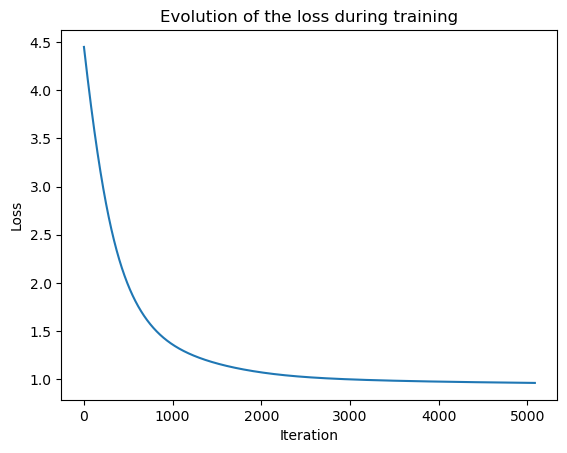

In [289]:
import matplotlib.pyplot as plt

# instantiate the classifier
# (we need to do this again because you probably changed the code of SoftmaxRegressionClassifier
# after you ran the previous cell)
softmax_clf = SoftmaxRegressionClassifier()
# train the classifier
loss_hist = softmax_clf.fit(X_train, y_train)

assert softmax_clf.weights is not None, ("`fit` method not implemented yet or not "
"updating the `weights` attribute.")
assert softmax_clf.biases is not None, ("`fit` method not implemented yet or not "
"updating the `biases` attribute.")
assert softmax_clf.weights.shape == (11, 6) and softmax_clf.biases.shape == (6,), ("`fit` "
"method should create the `weights` and `biases` attributes with the "
"correct shapes.")
assert loss_hist is not None, ("`fit` method not implemented yet or not "
"returning a valid array.")

# plot the evolution of the loss during training
plt.plot(loss_hist)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Evolution of the loss during training")
plt.show()

### 2.5
To finish the implementation of the classifier, you still need to **implement the `predict` method**, which again is analogous to the same method of the `LDAClassifier`.

After implementing the function, run the cell below to make sure that all the assertions pass and that the values of the training and test accuracies are reasonable.

In [292]:
# instantiate the classifier and train it
# (we need to do this again because you probably changed the code of SoftmaxRegressionClassifier
# after you ran the previous cell)
softmax_clf = SoftmaxRegressionClassifier()
softmax_clf.fit(X_train, y_train)

# predict the class labels for the training data
y_train_pred = softmax_clf.predict(X_train)
assert y_train_pred is not None, ("`predict` method not implemented yet or not returning "
"any predictions.")
assert len(y_train_pred) == len(X_train), ("You should have one predicted "
"label for each input example.")
print("Your classifier predicted:")
for j in range(6):
    print(f"  * {(y_train_pred == j).sum()} training examples in class {j}.")
print()

# predict the class labels for the test data
y_test_pred = softmax_clf.predict(X_test)
assert y_test_pred is not None, ("`predict` method not implemented yet or not returning "
"any predictions.")
assert len(y_test_pred) == len(X_test), ("You should have one predicted "
"label for each input example.")
print("Your classifier predicted:")
for j in range(6):
    print(f"  * {(y_test_pred == j).sum()} test examples in class {j}.")
print()

# compute the training accuracy
train_accuracy = compute_accuracy(y_train, y_train_pred)
print(f"Training accuracy: {train_accuracy:.3f}")

# compute the test accuracy
test_accuracy = compute_accuracy(y_test, y_test_pred)
print(f"Test accuracy: {test_accuracy:.3f}")


Your classifier predicted:
  * 0 training examples in class 0.
  * 3 training examples in class 1.
  * 547 training examples in class 2.
  * 487 training examples in class 3.
  * 82 training examples in class 4.
  * 0 training examples in class 5.

Your classifier predicted:
  * 0 test examples in class 0.
  * 0 test examples in class 1.
  * 234 test examples in class 2.
  * 209 test examples in class 3.
  * 37 test examples in class 4.
  * 0 test examples in class 5.

Training accuracy: 0.614
Test accuracy: 0.548


### 2.6
Based on the accuracy values, **which of the two classifiers**, `SoftmaxRegClassifier` or `LDAClassifier`, **would you choose** to solve this classification problem? Justify your answer.

*Your answer here*

We would choose the `LDAClassifier`.

We prioritize the test accuracy value because it reflects how well the model generalizes to unseen data. Therefore, we selected the classifier with the test accuracy closest to 1. Nevertheless, the `LDAClassifier` had greater values in both the training and test settings.

### 2.7
Explain why normalizing features to have zero mean and unit variance is an important preprocessing step **for this classifier**.

*Your answer here*

This preprocessing step is important for some reasons:

- Normalization avoids biases caused by features with large scales, ensuring all features contribute equally to the learning process. This promotes balanced weight updates and leads to faster, more stable convergence during gradient descent

- Normalization reduces the risk of numerical instability during softmax computation by preventing extremely large or small exponentiated values. While other techniques (as we implemented earlier) can also address this, normalization remains a valuable step for mitigating such issues


## Problem 3: Ensemble Classifiers

In problems 1 and 2, you built two different classifiers for the in-hands problem. Now, you will build an *ensemble* using those classifiers, i.e. you will create a new classifier that uses the predictions of the individual classifiers and combines them to produce the final decision.

### 3.1
There are several different strategies to create classifier ensembles (e.g., hard voting, soft voting, or weighted voting). **Propose and explain the ensembling strategy** that you will use to combine the two classifiers.

*Your answer here*

We think the best strategy to combine these two classifiers is weighted voting, where we would assign a weight to the predictions of each classifier (e.g., based on the training accuracy or any other metric). However, for this problem, we only have the input $X$ and trained classifiers, which does not allow us to use such prior knowledge.

Therefore, taking into consideration the limitations of this problem, we propose a **soft voting** strategy to combine the predictions of the two classifiers. This method computes the predicted probabilities for each class from both classifiers, averages the corresponding probabilities across the classifiers, and then selects the class with the highest average probability.

### 3.2
Complete the code of the function `ensemble_predict`, whose skeleton is given below, by **implementing the ensembling strategy you proposed** in the previous question. This function receives:
- `X`: An array of shape `(num_examples, num_features)` containing the input examples $\mathbf{x}_1, \mathbf{x}_2, \dots, \mathbf{x}_n$ for which predictions are needed.
- `lda_clf`: An instance of `LDACLassifier`.
- `softmax_clf`: An instance of `SoftmaxRegressionClassifier`.

The function should return an array of shape `(num_examples,)` with the predicted labels for each input example.

After implementing the function, run the cell below to make sure that all the assertions pass and that the training and test accuracy values are reasonable.

In [297]:
def ensemble_predict(
    X: np.ndarray,
    lda_clf: LDAClassifier,
    softmax_clf: SoftmaxRegressionClassifier,
) -> np.ndarray:
    """
    Predict the class labels for the given input data using an ensemble classifier.

    Parameters:
    X: np.ndarray of shape (num_examples, num_features)
        The input data (features).
    lda_clf: LDAClassifier
        The LDAClassifier instance.
    softmax_clf: SoftmaxRegressionClassifier
        The SoftmaxRegressionClassifier instance.

    Returns:
    np.ndarray of shape (num_examples,)
        The predicted class labels.
    """
    # ToDo: Exercise 3.2
    lda_probs = lda_clf.predict_proba(X)
    softmax_probs = softmax_clf.predict_proba(X)

    ensemble_probs = (lda_probs + softmax_probs) / 2

    return np.argmax(ensemble_probs, axis=1)


# predict the class labels for the training data
y_train_pred = ensemble_predict(X_train, lda_clf, softmax_clf)
assert y_train_pred is not None, ("`ensemble_predict` method not implemented yet"
" or not returning any predictions.")
assert len(y_train_pred) == len(X_train), ("You should have one predicted "
"label for each input example.")
print("Your classifier predicted:")
for j in range(6):
    print(f"  * {(y_train_pred == j).sum()} training examples in class {j}.")
print()

# predict the class labels for the test data
y_test_pred = ensemble_predict(X_test, lda_clf, softmax_clf)
assert y_test_pred is not None, ("`ensemble_predict` method not implemented yet "
"or not returning any predictions.")
assert len(y_test_pred) == len(X_test), ("You should have one predicted "
"label for each input example.")
print("Your classifier predicted:")
for j in range(6):
    print(f"  * {(y_test_pred == j).sum()} test examples in class {j}.")
print()

# compute the training accuracy
train_accuracy = compute_accuracy(y_train, y_train_pred)
print(f"Training accuracy: {train_accuracy:.3f}")

# compute the test accuracy
test_accuracy = compute_accuracy(y_test, y_test_pred)
print(f"Test accuracy: {test_accuracy:.3f}")

Your classifier predicted:
  * 6 training examples in class 0.
  * 0 training examples in class 1.
  * 549 training examples in class 2.
  * 473 training examples in class 3.
  * 91 training examples in class 4.
  * 0 training examples in class 5.

Your classifier predicted:
  * 1 test examples in class 0.
  * 1 test examples in class 1.
  * 235 test examples in class 2.
  * 199 test examples in class 3.
  * 44 test examples in class 4.
  * 0 test examples in class 5.

Training accuracy: 0.623
Test accuracy: 0.552


### 3.3
Based on the accuracy values, **would you prefer the ensemble classifier or one of the classifiers individually**? Justify your answer.

*Your answer here*

We would choose the `LDAClassifier`.

As mentioned before, test accuracy is the most important metric because it reflects how well the model generalizes to unseen data. While the ensemble classifier slightly improves over the `SoftmaxRegClassifier`, it does not outperform the `LDAClassifier` in terms of test accuracy.

Although the training accuracy is slightly better for the ensemble, this small improvement does not justify its added complexity, particularly because the `LDAClassifier` is simpler and less computationally expensive.